In [4]:
# !conda install -c conda-forge diffusers==0.8.0 -y
!conda install datasets==2.16.1 -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4


In [7]:
!huggingface-cli whoami

JesseGuerrero


In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("YaYaB/onepiece-blip-captions")
train_dataset = dataset["train"]


(…)-00000-of-00001-7e86e8a67581ad82.parquet:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/856 [00:00<?, ? examples/s]

In [3]:
from diffusers import StableDiffusionPipeline
import torch

# Load the pre-trained model
model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")


The cache for model files in Diffusers v0.14.0 has moved to a new location. Moving your existing cached models. This is a one-time operation, you can interrupt it or run it later by calling `diffusers.utils.hub_utils.move_cache()`.
/home/ubh496/.conda/envs/MAGA/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/ubh496/.conda/envs/MAGA/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/ubh496/.conda/envs/MAGA/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [24]:
# Load a processor for the CLIP model to handle text and image preprocessing
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define preprocessing function
def preprocess(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    texts = examples["text"]
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    inputs["prompt"] = texts  # Save the text as a 'prompt' for later
    return inputs

# Load the dataset and apply preprocessing
dataset = load_dataset("YaYaB/onepiece-blip-captions")
train_dataset = dataset["train"]

# Apply preprocessing
train_dataset = train_dataset.map(preprocess, batched=True)

# Define a custom collate function for DataLoader
def custom_collate_fn(batch):
    # Ensure pixel_values are properly converted to tensors before stacking
    pixel_values = torch.stack([torch.tensor(item['pixel_values']) if isinstance(item['pixel_values'], list) else item['pixel_values'] for item in batch])
    
    # Collect text prompts
    prompts = [item['prompt'] for item in batch]
    
    return {
        'pixel_values': pixel_values,
        'prompt': prompts
    }

# Create a PyTorch DataLoader with the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)


In [26]:
import torch.nn.functional as F
# Optimizer
optimizer = AdamW(model.unet.parameters(), lr=1e-5)

# Training loop
num_epochs = 5
model.unet.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()

        # Move input tensors to GPU
        pixel_values = batch["pixel_values"].to("cuda")
        prompt = batch["prompt"]  # Text prompt

        # Tokenize the text prompt (important step to fix the error)
        tokenized_prompt = processor.tokenizer(prompt, return_tensors="pt", padding=True).input_ids.to("cuda")

        # Encode the images into latents using VAE
        latents = model.vae.encode(pixel_values).latent_dist.sample()
        latents = latents * 0.18215  # Scale latents

        # Add noise to the latents
        noise = torch.randn_like(latents).to("cuda")
        timesteps = torch.randint(0, model.scheduler.config.num_train_timesteps, (latents.shape[0],), device="cuda").long()

        noisy_latents = model.scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from the text encoder using tokenized inputs
        text_embeddings = model.text_encoder(tokenized_prompt).last_hidden_state

        # Predict the noise with the U-Net
        noise_pred = model.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        # Compute the loss (MSE between predicted noise and actual noise)
        loss = F.mse_loss(noise_pred, noise)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} completed with loss: {loss.item()}")

Epoch 1/5 completed with loss: 0.31488749384880066
Epoch 2/5 completed with loss: 0.12578679621219635
Epoch 3/5 completed with loss: 0.25237560272216797
Epoch 4/5 completed with loss: 0.20395129919052124
Epoch 5/5 completed with loss: 0.1516755372285843


In [27]:
model.save_pretrained("./fine-tuned-stable-diffusion")


In [28]:
from diffusers import StableDiffusionPipeline
import torch

# Load the fine-tuned model
model_path = "./fine-tuned-stable-diffusion"  # Path where your fine-tuned model is saved
pipeline = StableDiffusionPipeline.from_pretrained(model_path).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

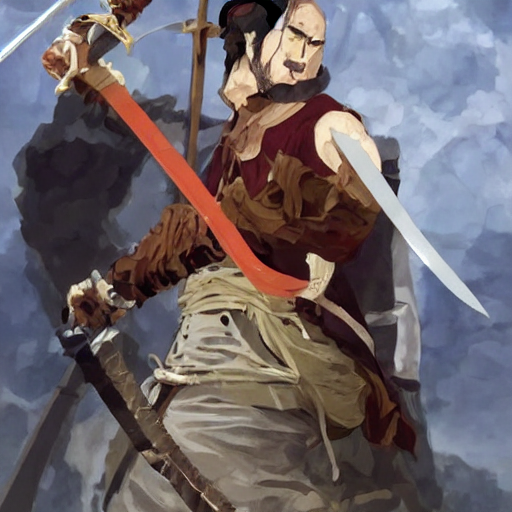

In [32]:
from PIL import Image

prompt = "A man with a sword"

# Generate an image from the prompt
with torch.autocast("cuda"):
    image = pipeline(prompt).images[0]

# Save the generated image
image.save("generated_image.png")

# Display the image using PIL's Image.show() (this should work without external dependencies)
image


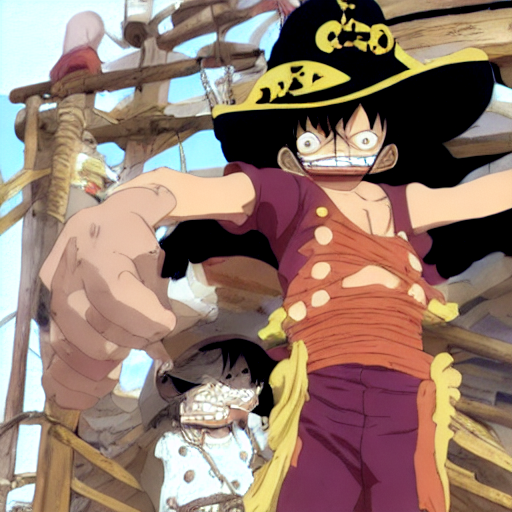

In [31]:
image